# Spheres from weights

[NiftiSpheresMasker documentation](https://nilearn.github.io/stable/modules/generated/nilearn.maskers.NiftiSpheresMasker.html)

In [17]:
import os
import pandas as pd
import numpy as np
from nilearn.maskers import NiftiSpheresMasker, NiftiMasker
from nilearn.image import math_img
from nilearn.glm import threshold_stats_img

In [3]:
# Settings
data_dir = "/Volumes/T7/BIDS-BRAINPLAYBACK-TASK2/"
# glm_dir = os.path.join(data_dir, "derivatives", "nilearn_glm")
features_dir = os.path.join(data_dir, "derivatives", "mvpa_08_stability_bold", "features_full")
stab_mask_dir = os.path.join(data_dir, "derivatives", "mvpa_08_stability_bold", "stab_full_masks")  # for stability masks

# Threshold values
hc = "fpr"  # None, 'bonferroni', 'fdr'
ct = 20  # cluster threshold
alpha = 0.001  # p-value threshold

emotion_names = [
    "JoyfulActivation",
    "Nostalgia",
    "Peacefulness",
    "Power",
    "Sadness",
    "Tenderness",
    "Tension",
    "Transcendence",
    "Wonder",
]

factors_names = [
    "Sublimity",
    "Vitality",
    "Unease",
]

subject_list = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20"]

In [4]:
# Clusters
cluster_file_path = "out_atlasreader/atlas_ALL_peaks.csv"

df = pd.read_csv(cluster_file_path)

# Extract the coordinates
coords = df[["peak_x", "peak_y", "peak_z"]].values
coords

array([[-56.5, -16.5,   3.5],
       [ 57.5, -10.5,   3.5],
       [-10.5,  -6.5,  65.5],
       [ 55.5,  -4.5,  43.5],
       [-18.5, -66.5,  47.5],
       [ 39.5,  59.5,  -8.5],
       [ 33.5, -66.5,  47.5],
       [-48.5,  13.5,  27.5],
       [-18.5,  63.5,  17.5],
       [-64.5, -56.5,  -6.5],
       [-50.5,  27.5,  -8.5],
       [ 37.5,  45.5,  33.5],
       [ 11.5, -64.5,  33.5],
       [ 57.5, -60.5,  -4.5],
       [ 55.5,  33.5,   3.5],
       [ 65.5, -52.5,   9.5],
       [ 59.5, -42.5,  45.5],
       [-24.5,  -4.5, -18.5],
       [ 63.5, -28.5, -18.5],
       [  3.5, -36.5,  45.5],
       [ 43.5, -64.5, -32.5],
       [  5.5, -22.5,  43.5],
       [-56.5,  19.5,  13.5],
       [  7.5, -76.5,  55.5],
       [ -8.5,  49.5,  -6.5],
       [-40.5,  55.5, -12.5],
       [ 25.5,  61.5,  17.5]])

# All subjects

In [35]:
# Initalize FEAT, an array with dims n_subjects x n_emotions x n_clusters
n_subjects = len(subject_list)
n_emotions = len(emotion_names)
n_clusters = len(coords)

FEAT = np.zeros((n_subjects, n_emotions, n_clusters))

# Iterate over subjects
for i, subject in enumerate(subject_list):
    print(f"Processing subject {subject}")

    # Load the features
    E = np.load(os.path.join(features_dir, f"sub-{subject}_ses-01_task-02a_run-1_features.npy"))
    for run in range(2, 5):
        E = np.concatenate(
            (E, np.load(os.path.join(features_dir, f"sub-{subject}_ses-01_task-02a_run-{run}_features.npy"))),
            axis=0,
        )

    # Load the labels
    L = np.load(os.path.join(features_dir, f"sub-{subject}_ses-01_task-02a_run-1_labels.npy"), allow_pickle=True)
    for run in range(2, 5):
        L = np.concatenate(
            (L, np.load(os.path.join(features_dir, f"sub-{subject}_ses-01_task-02a_run-{run}_labels.npy"), allow_pickle=True)),
            axis=0,
        )

    # Average the features per label
    E_avg = np.zeros((n_emotions, E.shape[1]))
    for i, label in enumerate(emotion_names):
        E_avg[i, :] = np.mean(E[L == label], axis=0)

    # Load the stability mask for this subject
    stab_mask_sub = os.path.join(stab_mask_dir, f"sub-{subject}_STAB_mask.nii.gz")

    # Create the masker
    masker = NiftiMasker(mask_img=stab_mask_sub, standardize=False, detrend=False)
    masker.fit()

    # Inverse transform the features
    E_avg_inv = masker.inverse_transform(E_avg)

    # Define Sphere Masker
    masker_sphere = NiftiSpheresMasker(coords, radius=4, standardize=False, detrend=False)

    # Extract the features for the clusters
    E_cluster = masker_sphere.fit_transform(E_avg_inv)

    # Store the features
    FEAT[i, :] = E_cluster


Processing subject 01
Processing subject 02
Processing subject 03
Processing subject 04
Processing subject 05
Processing subject 06
Processing subject 07
Processing subject 08
Processing subject 09
Processing subject 10
Processing subject 11
Processing subject 12
Processing subject 13
Processing subject 14
Processing subject 15
Processing subject 16
Processing subject 17
Processing subject 18
Processing subject 19
Processing subject 20


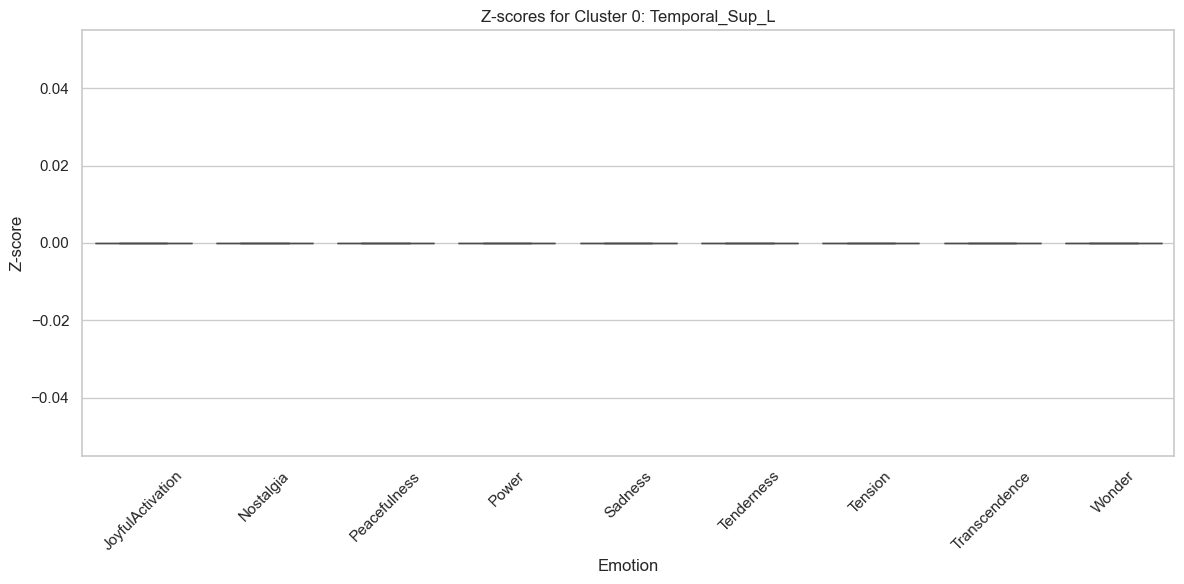

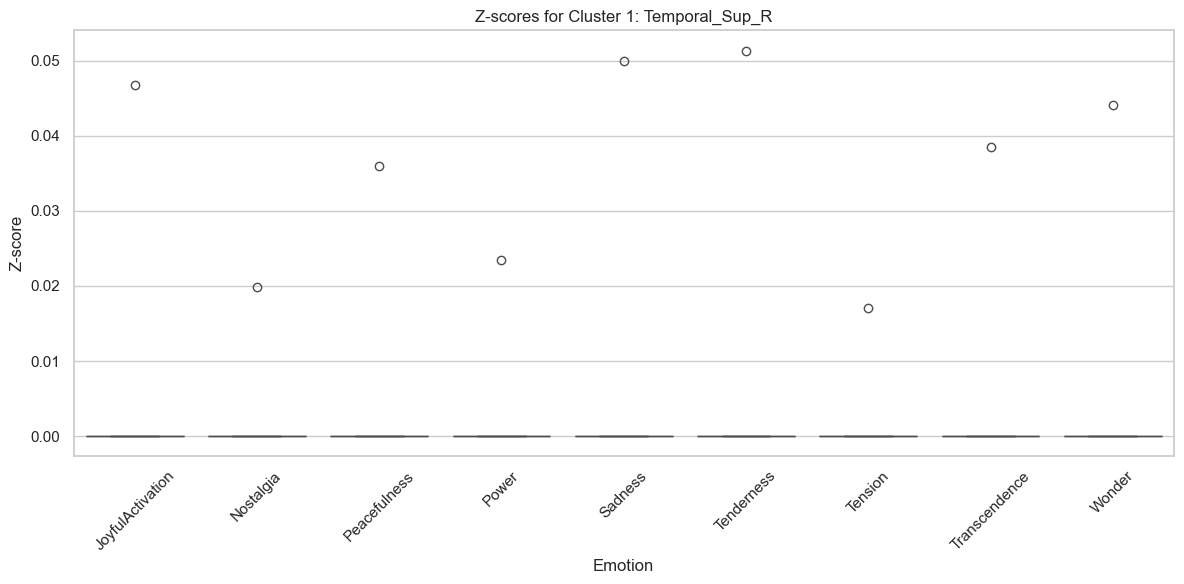

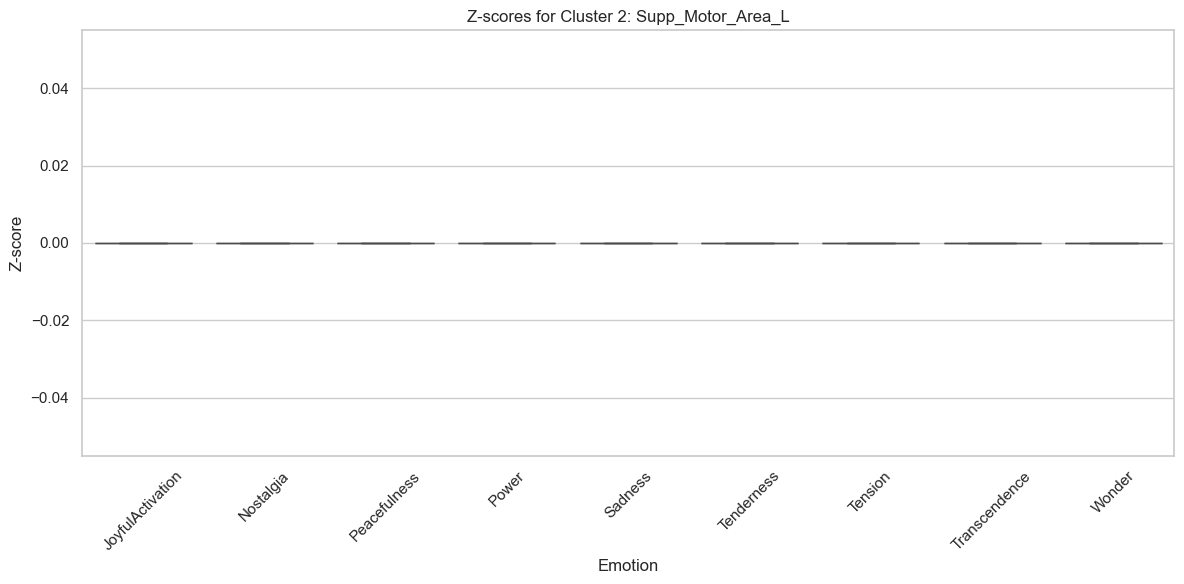

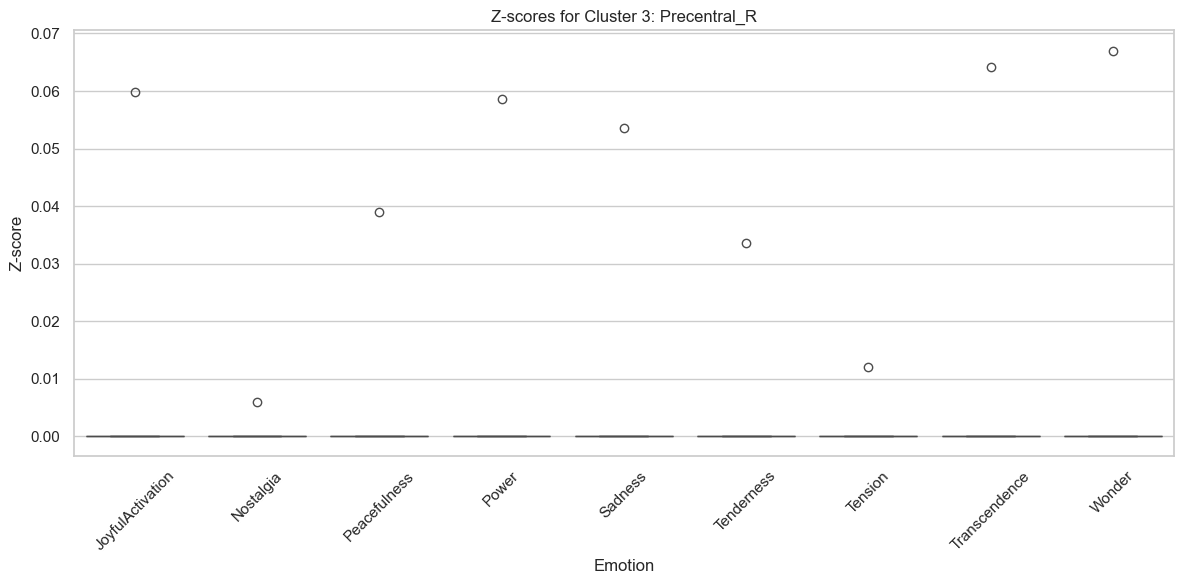

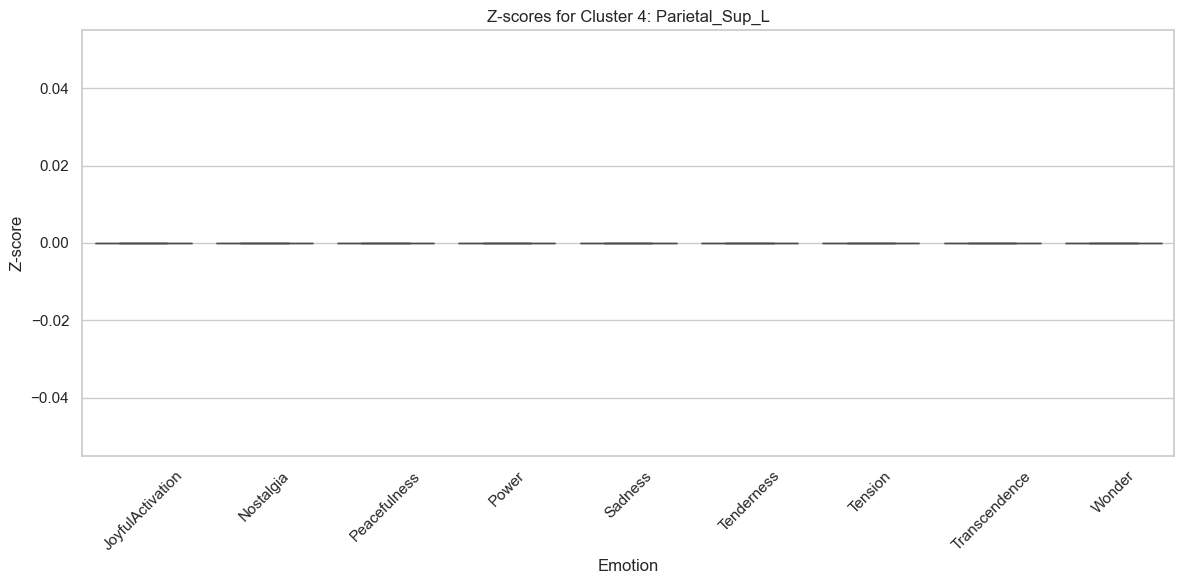

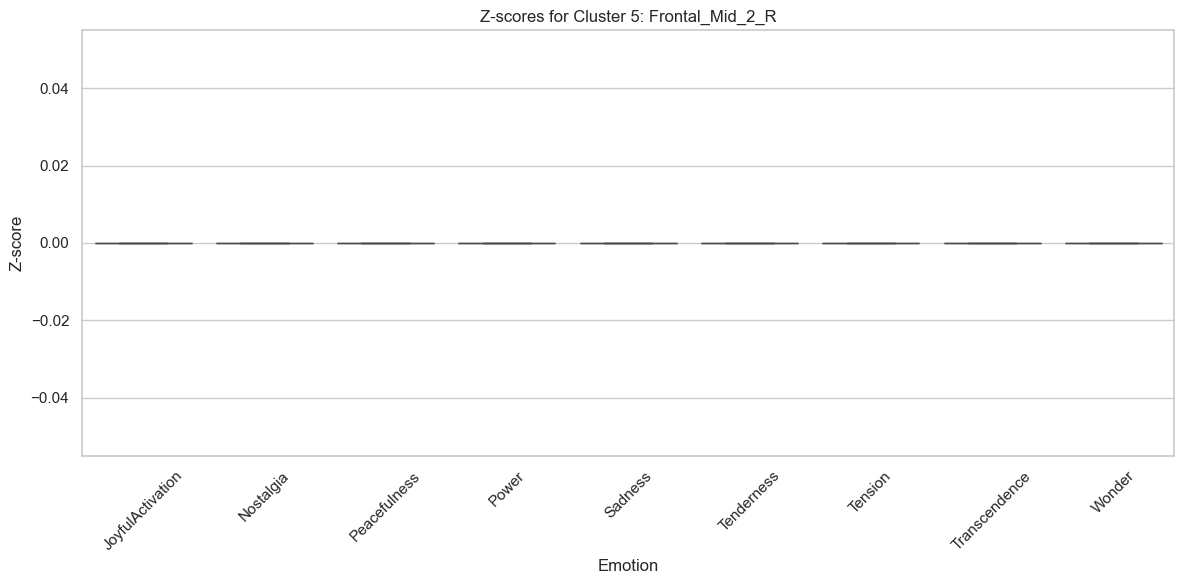

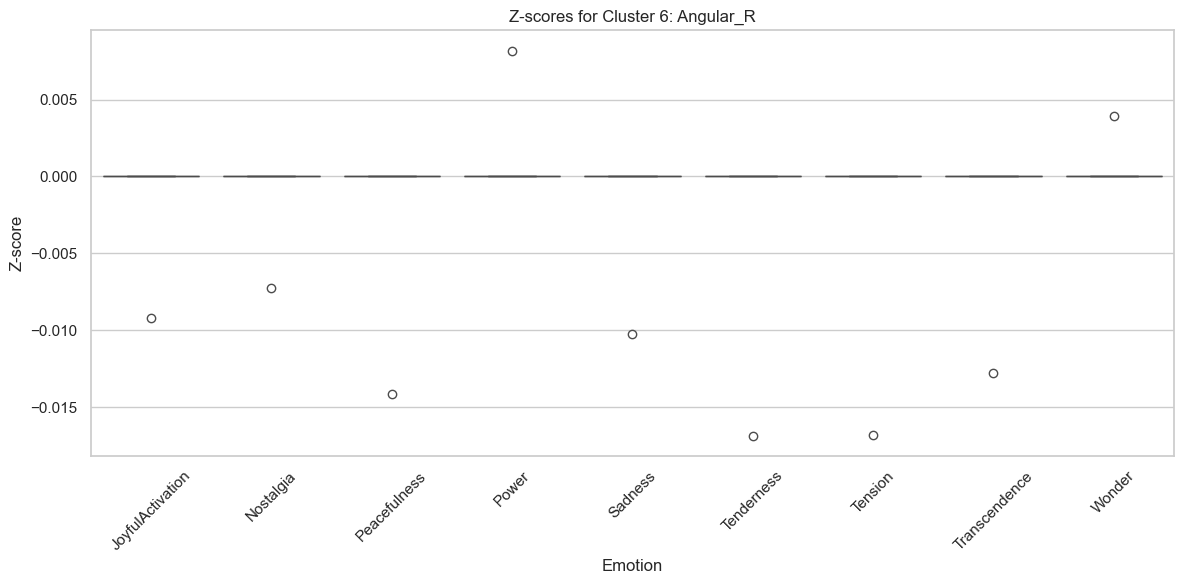

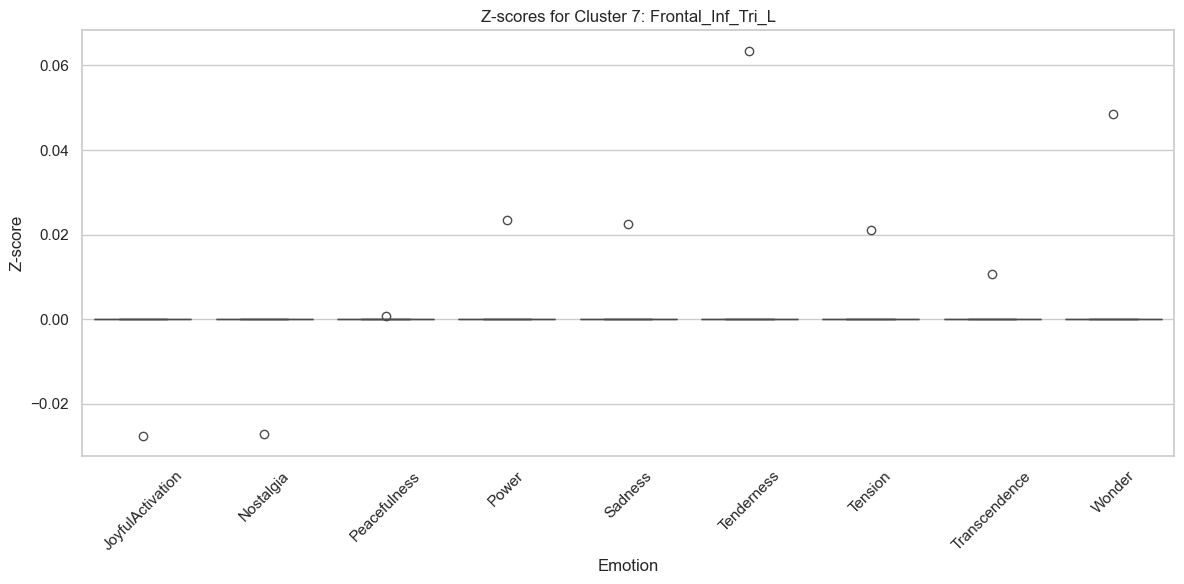

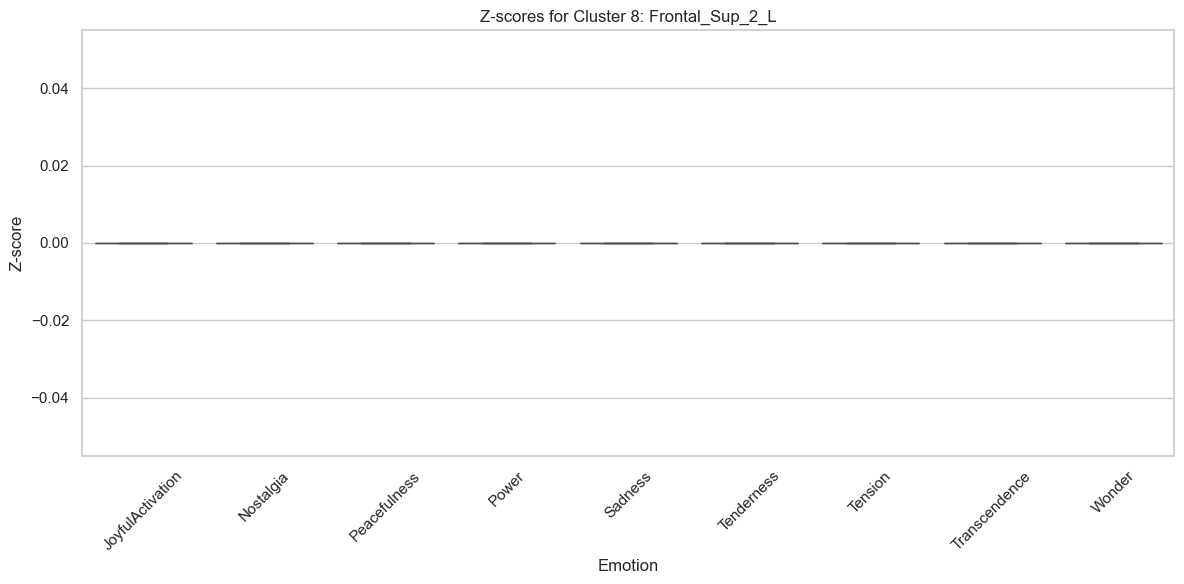

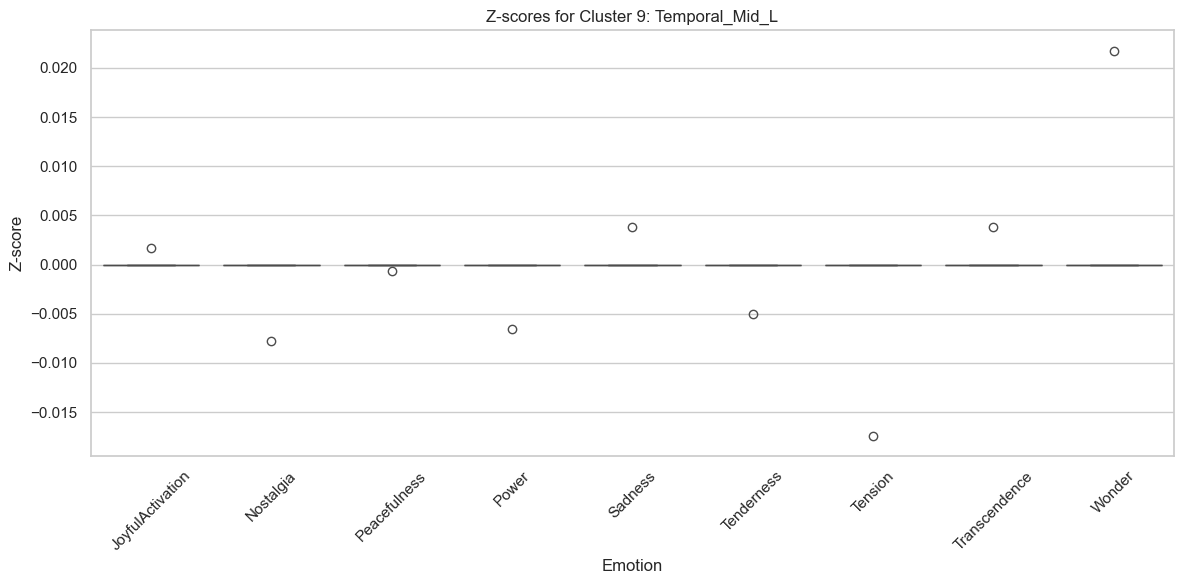

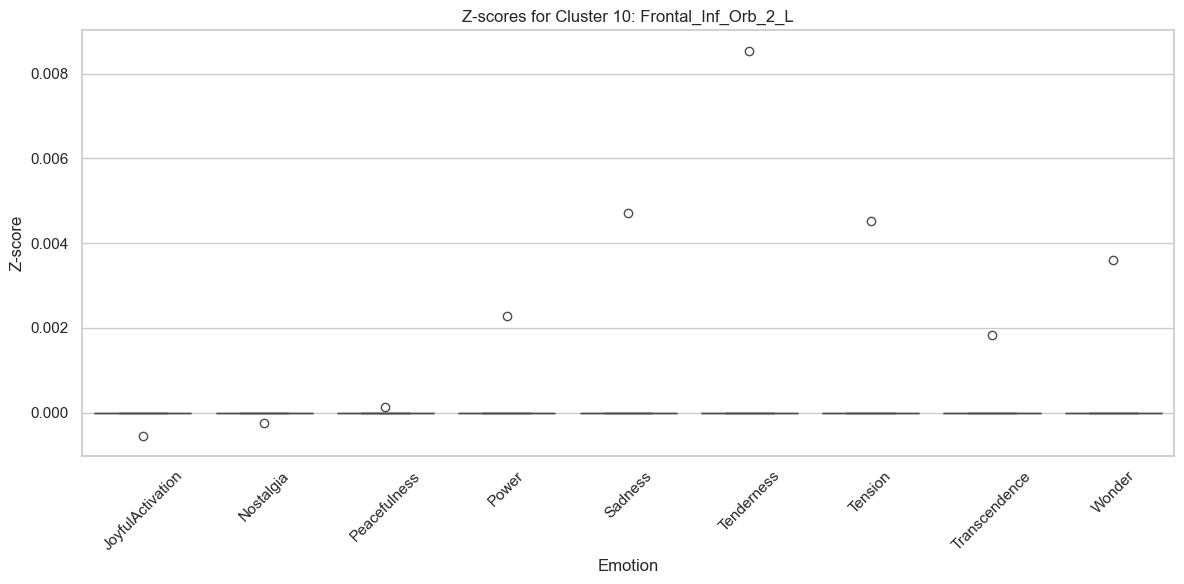

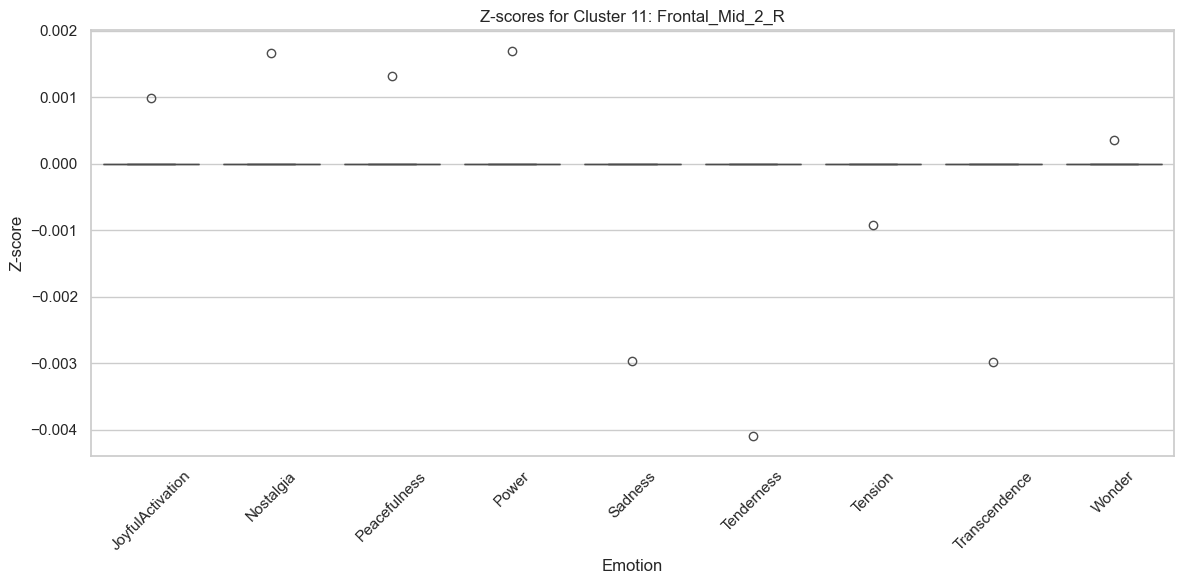

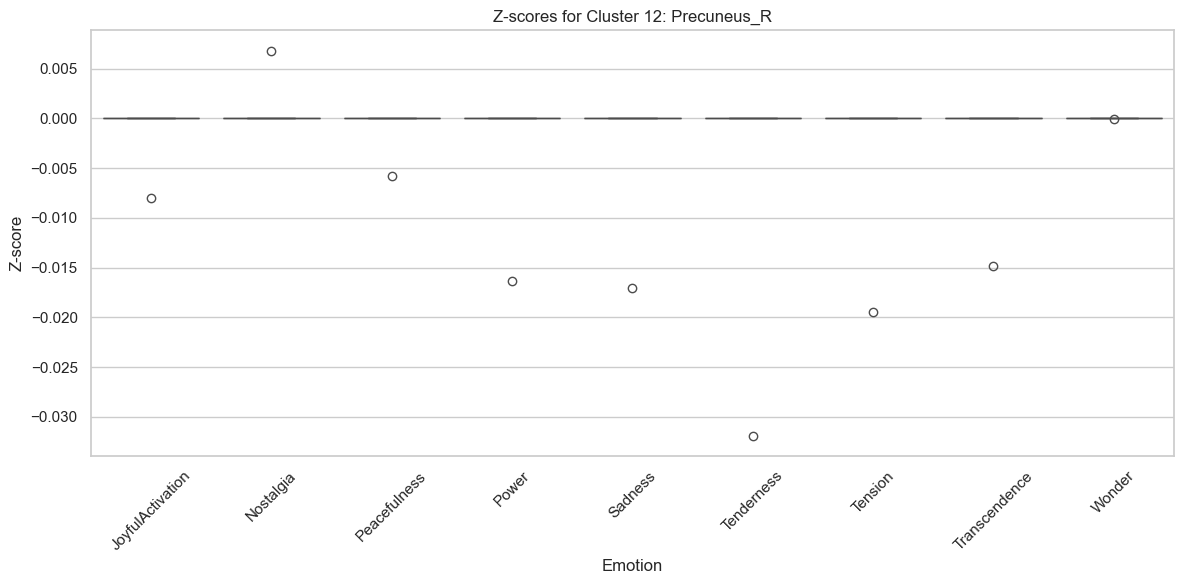

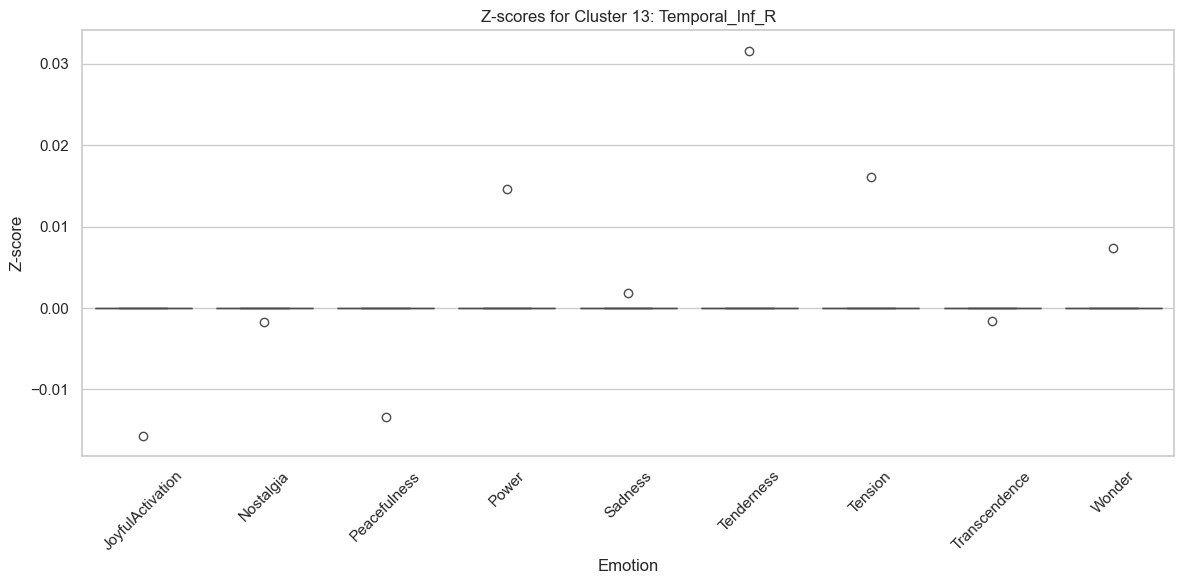

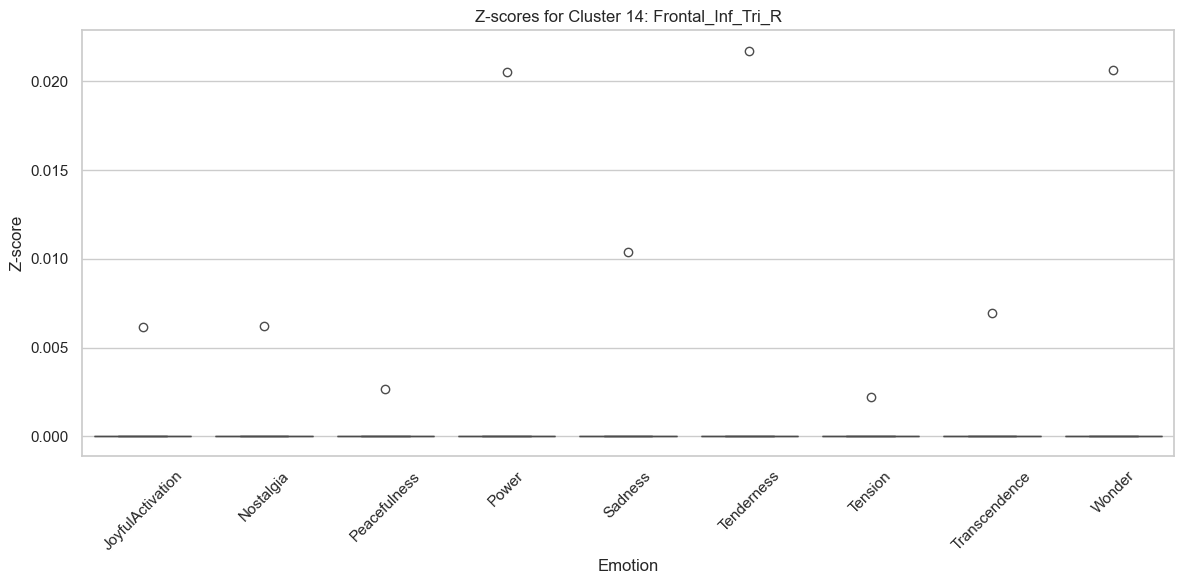

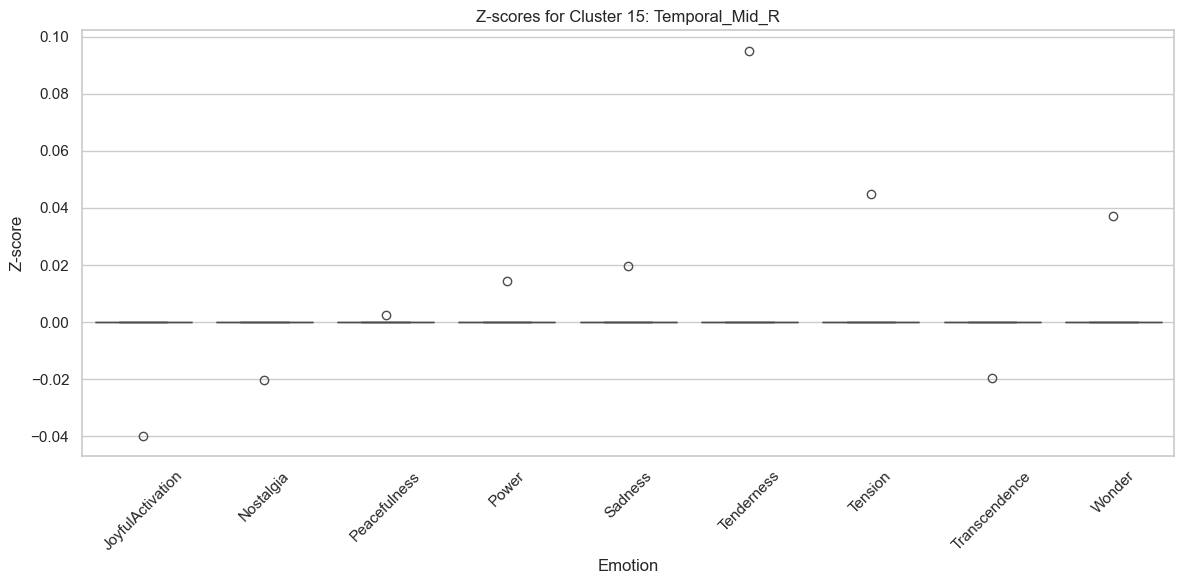

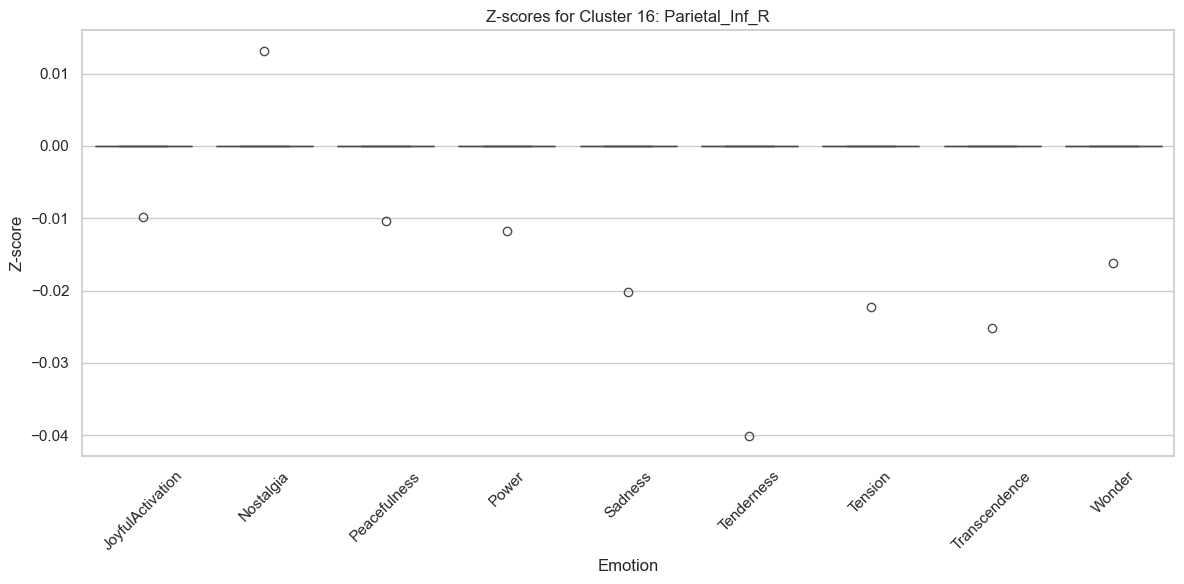

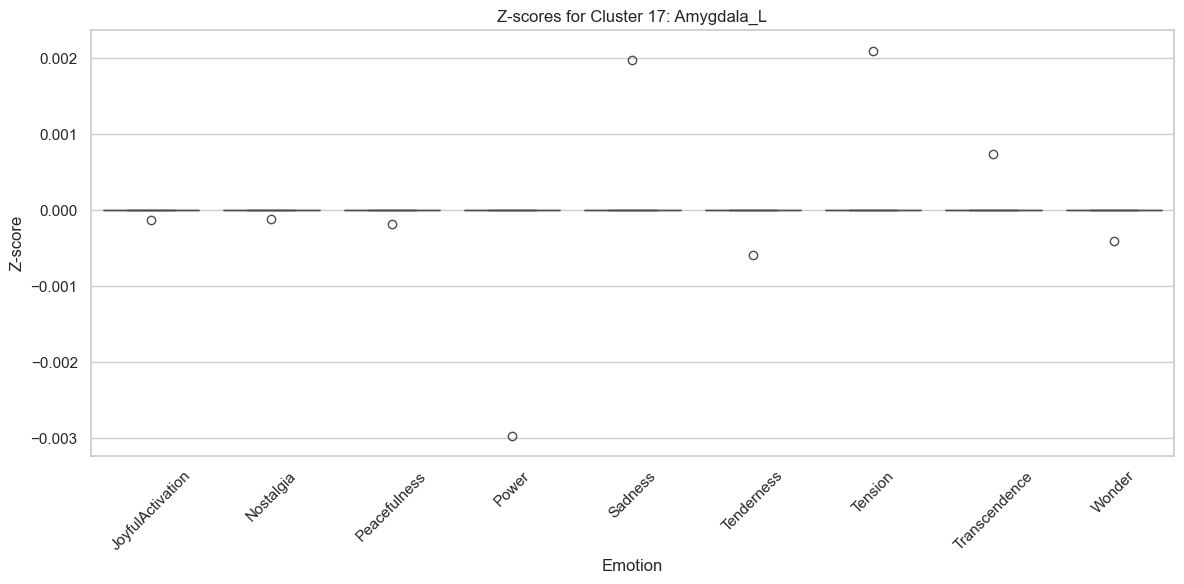

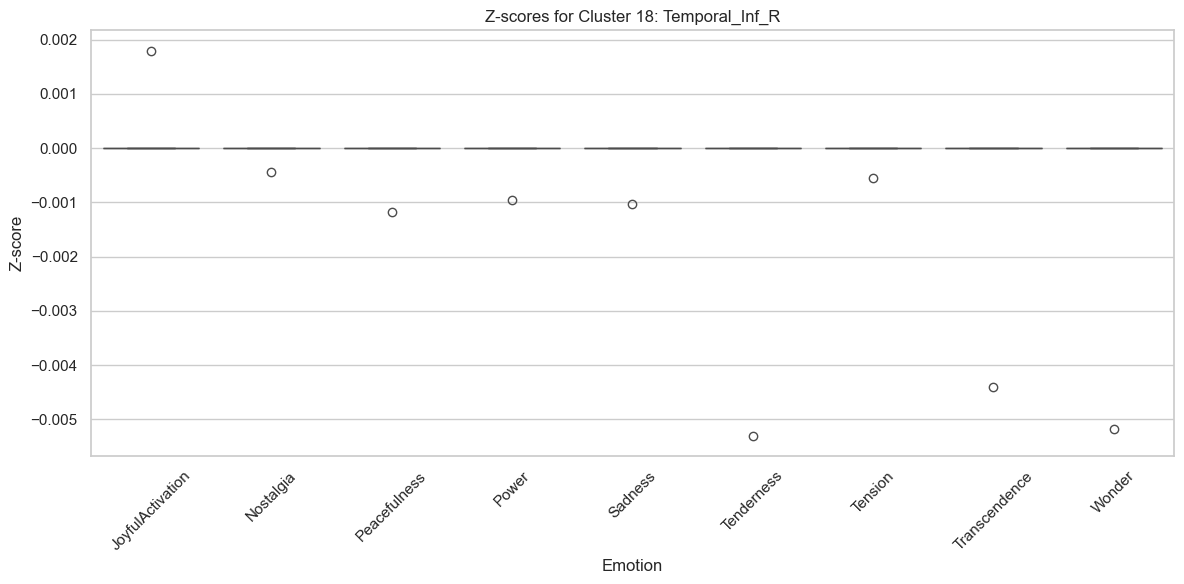

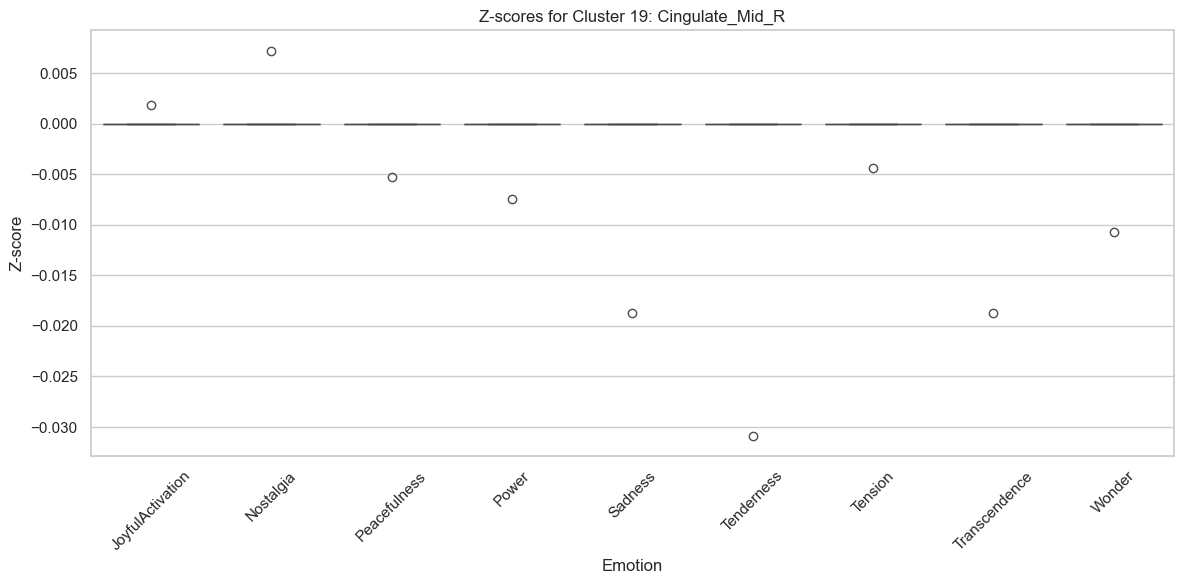

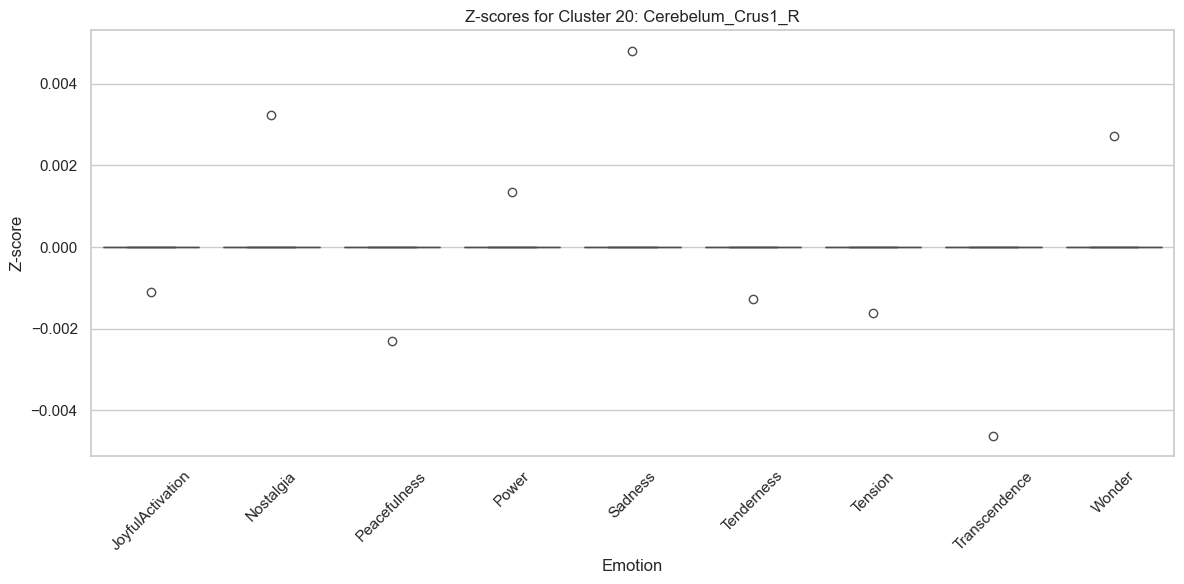

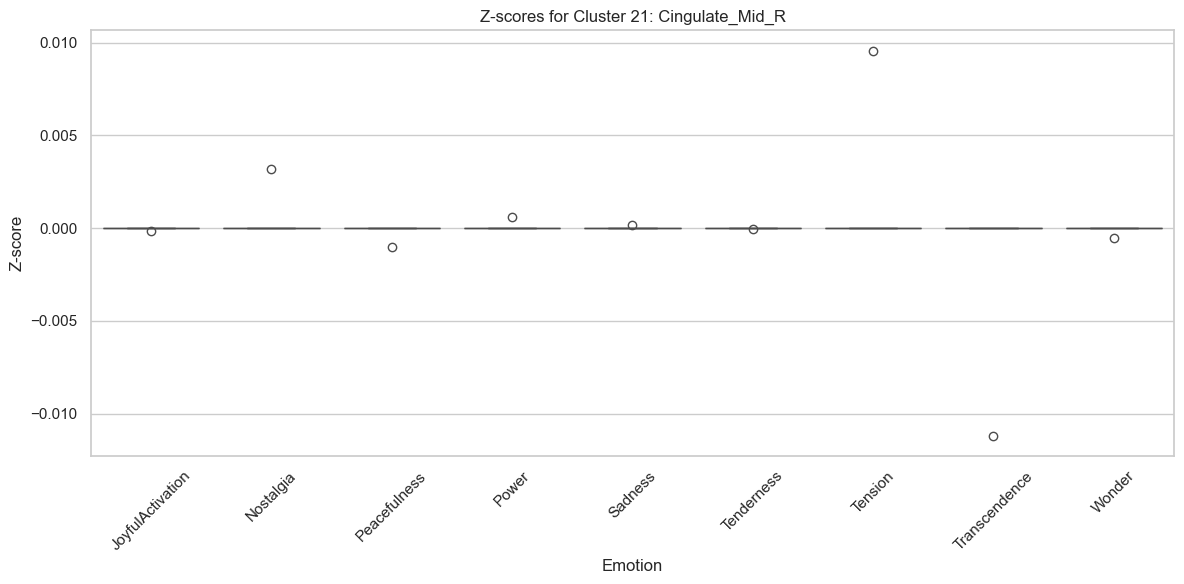

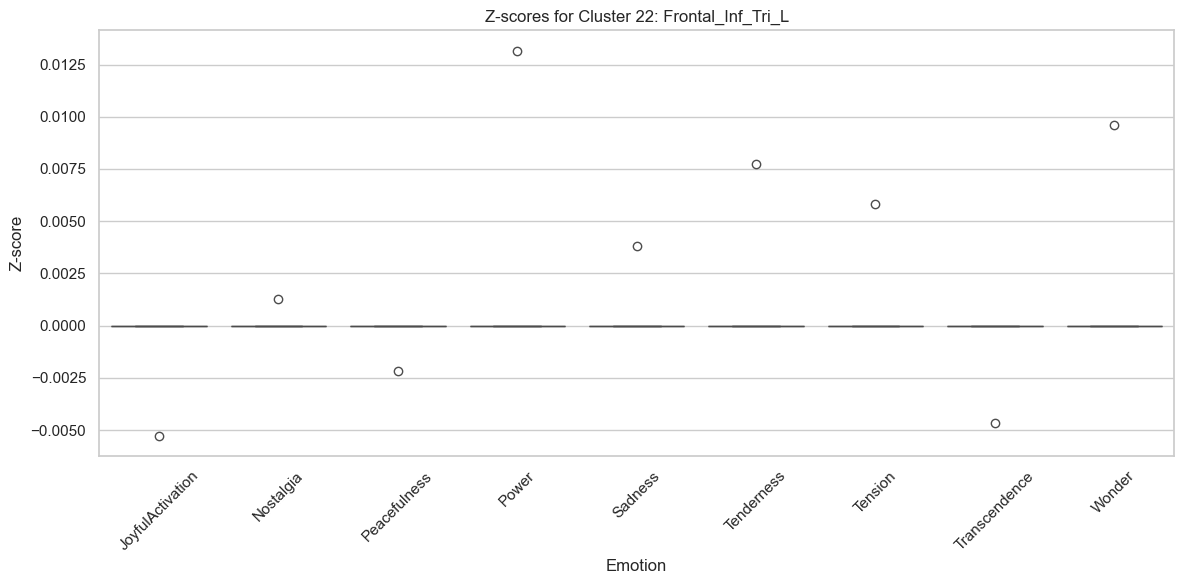

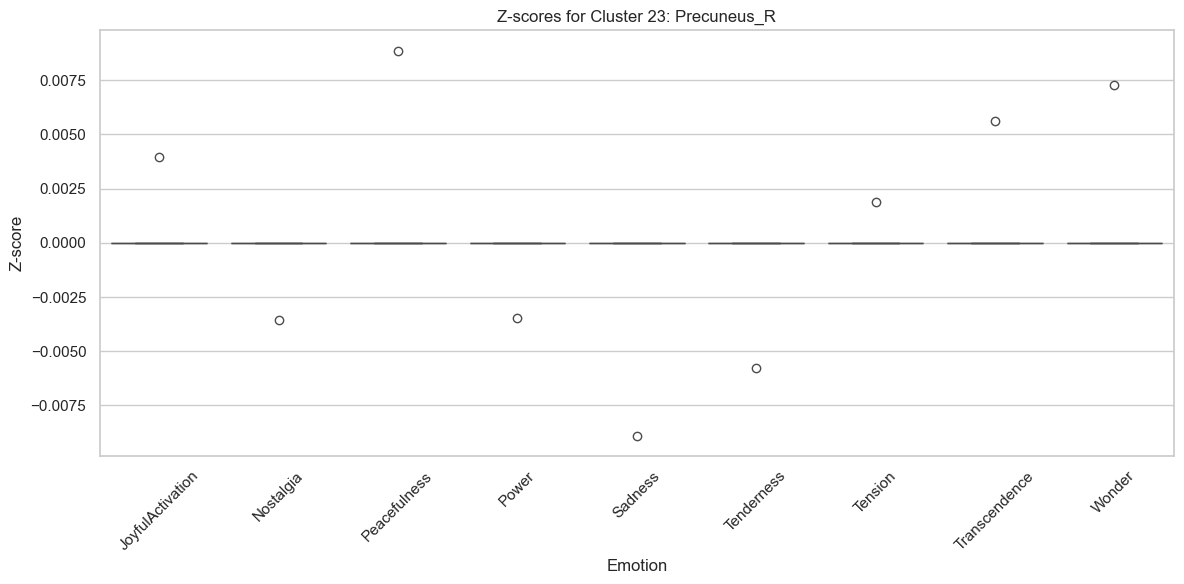

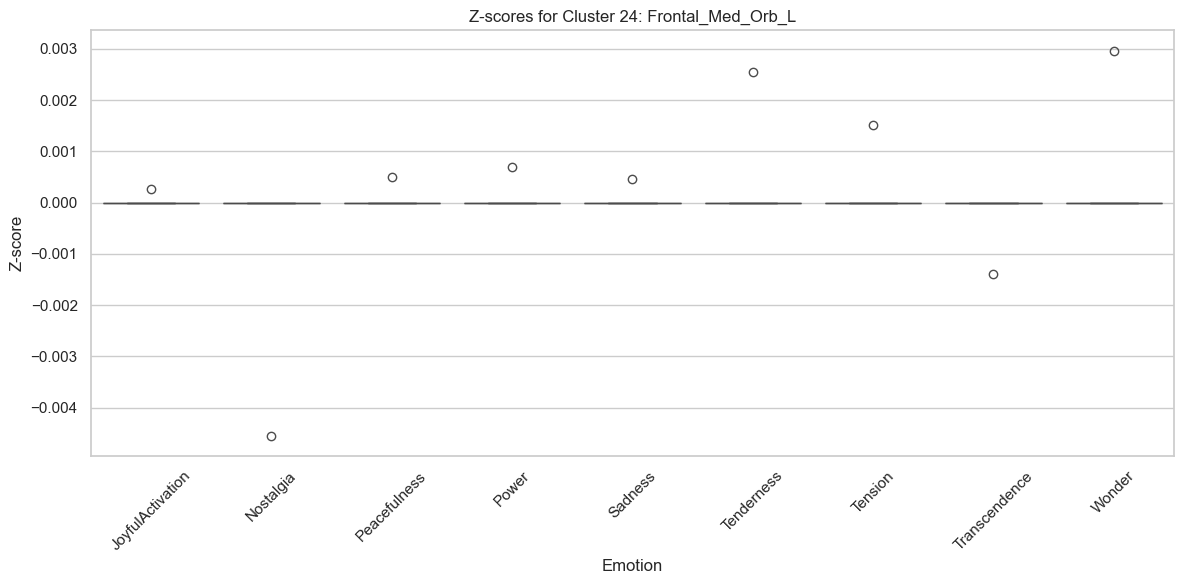

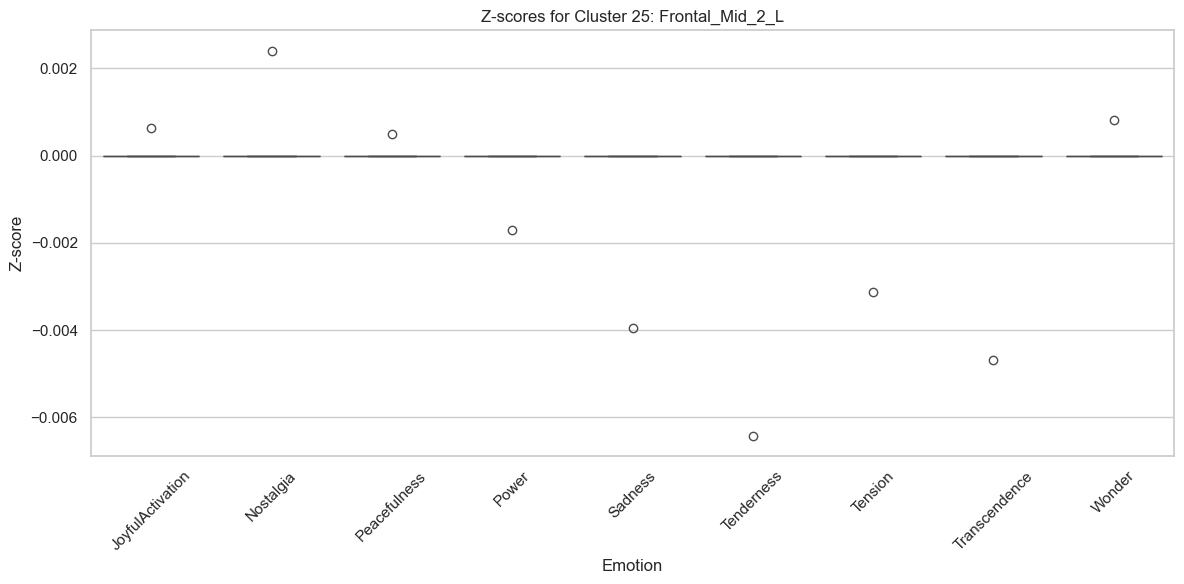

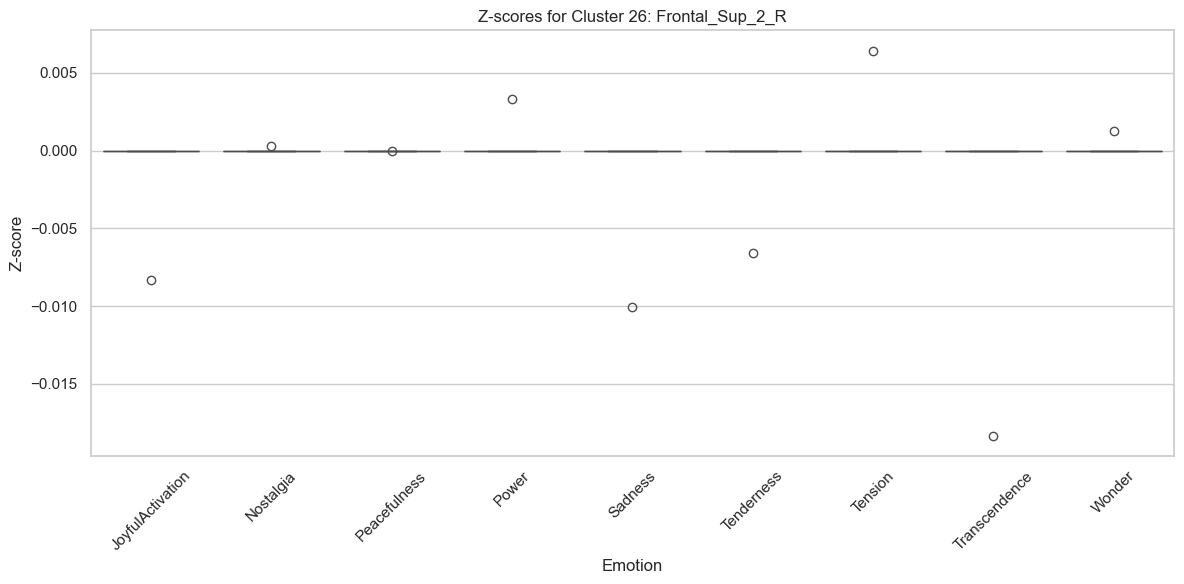

In [36]:
import seaborn as sns
from statannotations.Annotator import Annotator
import matplotlib.pyplot as plt

# Create a DataFrame
FEAT_df = pd.DataFrame(
    FEAT.reshape(n_subjects * n_emotions, n_clusters),
    columns=[f"Cluster {i}" for i in range(n_clusters)],
)
FEAT_df["Emotion"] = np.tile(emotion_names, len(subject_list))
FEAT_df["Subject"] = np.repeat(subject_list, len(emotion_names))

# Define pairs of emotions for comparison
pairs = [(emotion1, emotion2) for i, emotion1 in enumerate(emotion_names) for emotion2 in emotion_names[i + 1 :]]

# Plot
sns.set_theme(style="whitegrid")

# Iterate over all clusters
for cluster_idx, cluster in enumerate(FEAT_df.columns[:-2]):  # Exclude "Emotion" and "Subject" columns
    plt.figure(figsize=(12, 6))
    ax = sns.boxplot(x="Emotion", y=cluster, data=FEAT_df)
    ax.set_title(f"Z-scores for {cluster}: {df.iloc[cluster_idx]['aal']}")
    ax.set_ylabel("Z-score")
    ax.set_xlabel("Emotion")
    plt.xticks(rotation=45)

    # Add statistical annotations
    annotator = Annotator(ax, pairs, data=FEAT_df, x="Emotion", y=cluster)
    annotator.configure(test="Mann-Whitney", text_format="star", loc="inside", verbose=0, hide_non_significant=True, comparisons_correction=None)
    annotator.apply_and_annotate()

    plt.tight_layout()
    plt.show()

# Single subject

In [ ]:
# load sub-01_ses-01_task-02a_run-*_features.npy and concatenate
E = np.load(os.path.join(features_dir, "sub-01_ses-01_task-02a_run-1_features.npy"))
for run in range(2, 5):
    E = np.concatenate(
        (E, np.load(os.path.join(features_dir, f"sub-01_ses-01_task-02a_run-{run}_features.npy"))),
        axis=0,
    )

E.shape

(288, 7410)

In [ ]:
# Load the labels for all runs and concatenate
L = np.load(os.path.join(features_dir, "sub-01_ses-01_task-02a_run-1_labels.npy"), allow_pickle=True)
for run in range(2, 5):
    L = np.concatenate(
        (L, np.load(os.path.join(features_dir, f"sub-01_ses-01_task-02a_run-{run}_labels.npy"), allow_pickle=True)),
        axis=0,
    )
L.shape

(288,)

In [16]:
# Average the features per label
E_avg = np.zeros((len(np.unique(L)), E.shape[1]))
for i, label in enumerate(np.unique(L)):
    E_avg[i] = np.mean(E[L == label], axis=0)

E_avg.shape

(9, 7410)

In [21]:
# Load the stability mask for this subject
stab_mask_sub = os.path.join(stab_mask_dir, "sub-01_STAB_mask.nii.gz")

# Load the masker
masker = NiftiMasker(mask_img=stab_mask_sub, standardize=False, detrend=False)
masker.fit()

# Inverse transform the features
E_avg_inv = masker.inverse_transform(E_avg)
E_avg_inv.shape

(97, 115, 97, 9)

In [26]:
masker_sphere = NiftiSpheresMasker(coords, radius=2, standardize=False, detrend=False)

# Extract the features for the clusters
E_cluster = masker_sphere.fit_transform(E_avg_inv)
E_cluster.shape

(9, 27)

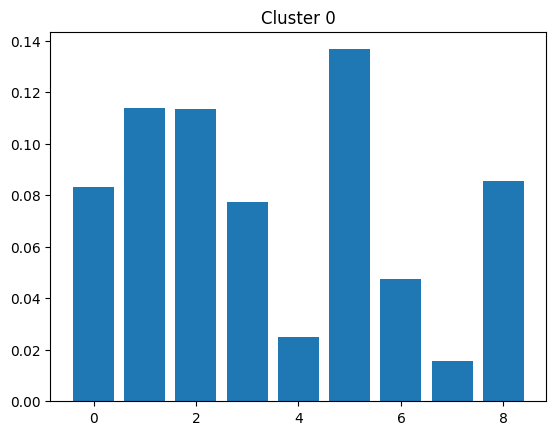

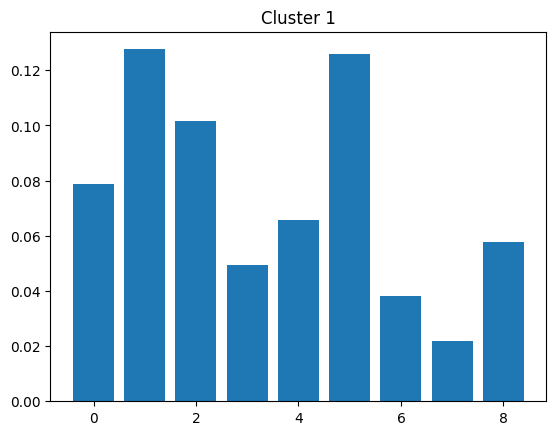

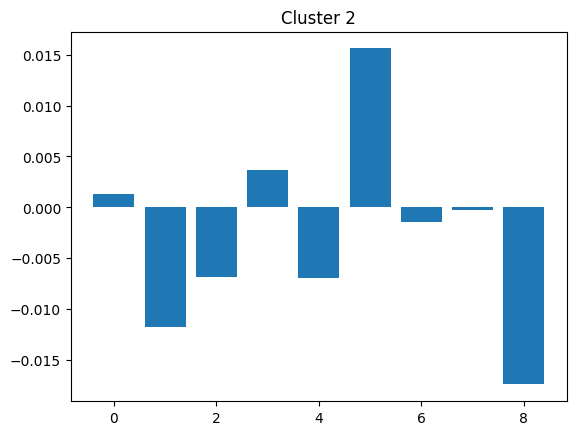

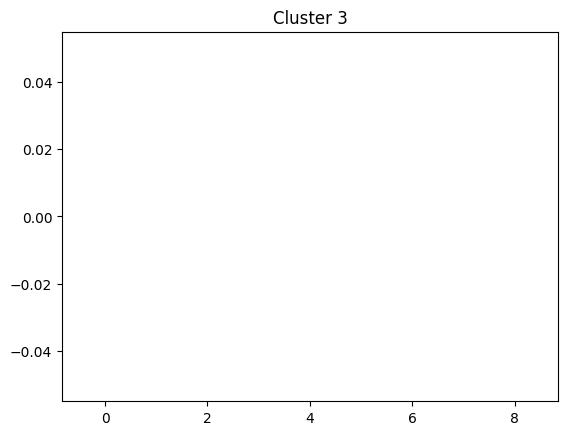

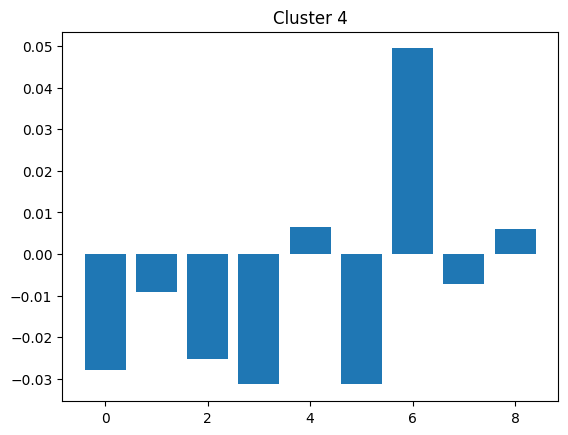

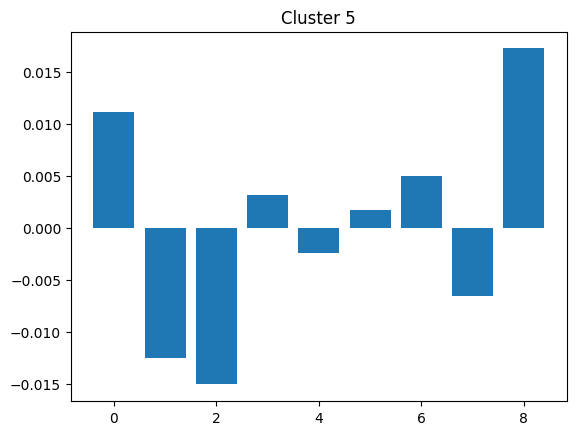

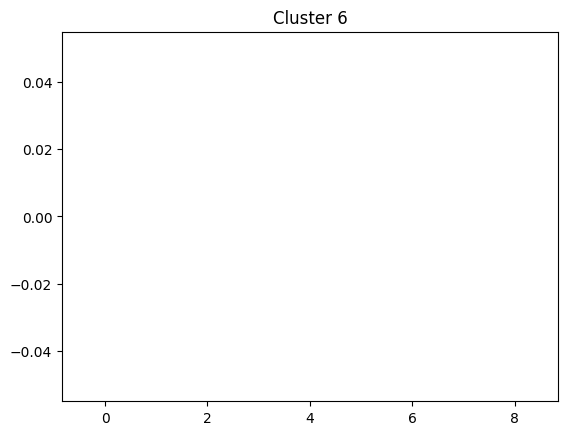

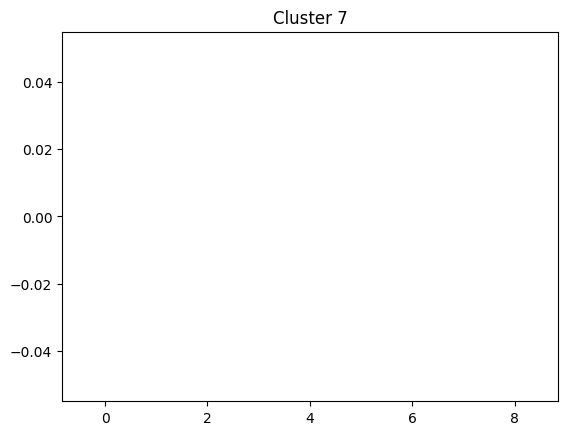

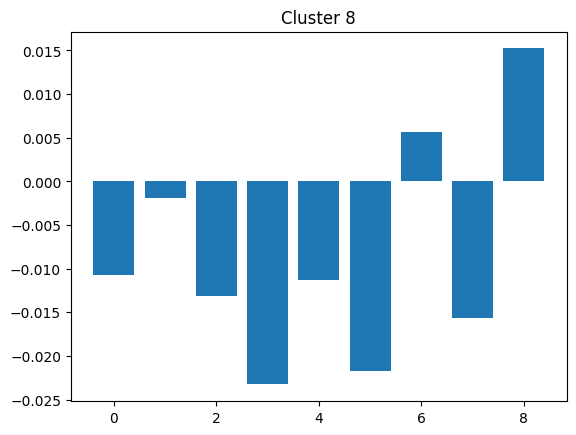

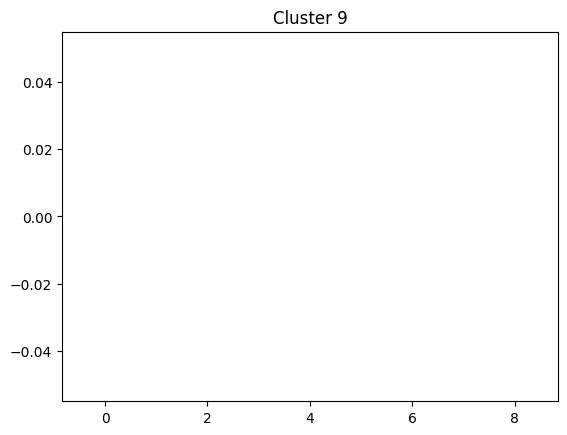

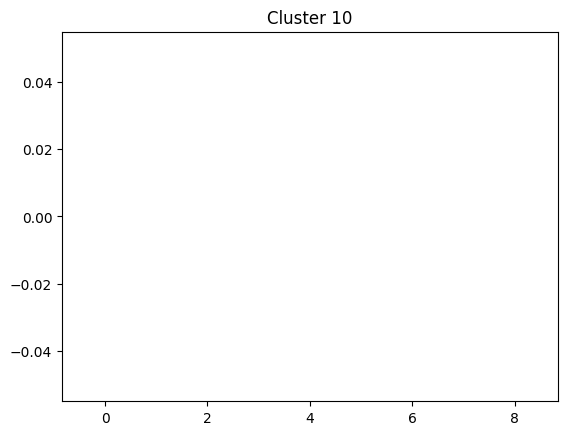

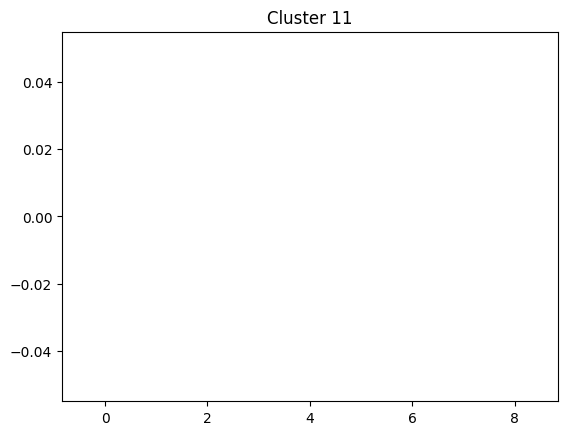

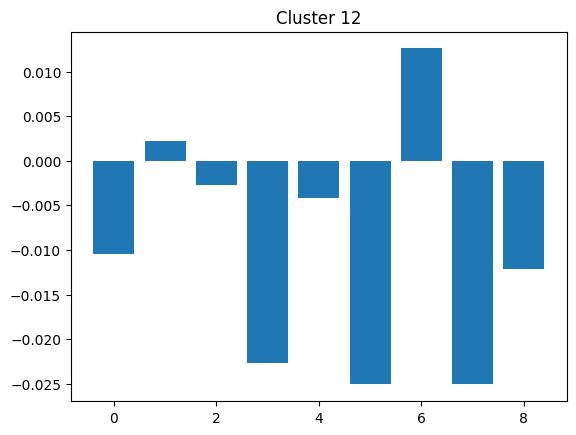

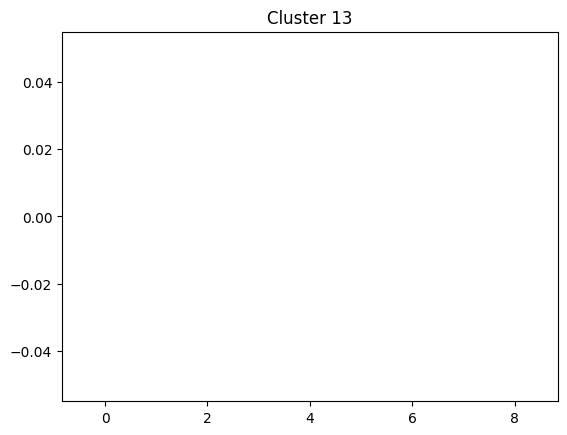

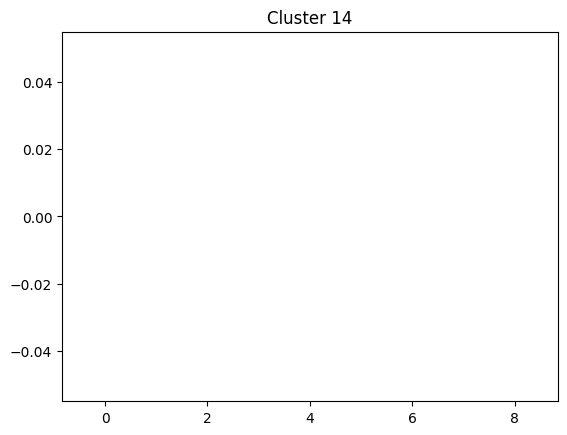

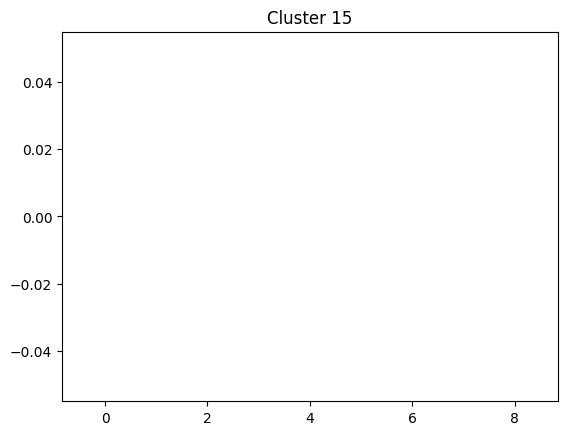

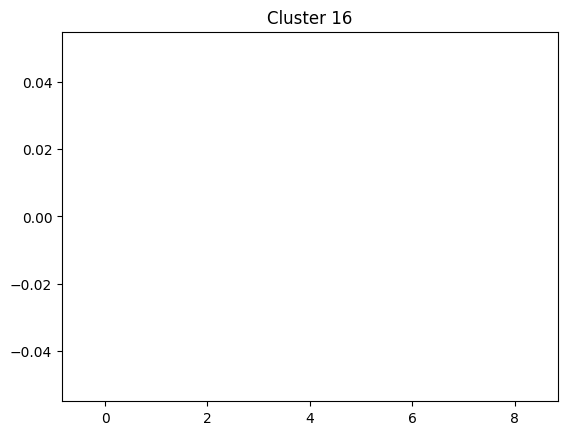

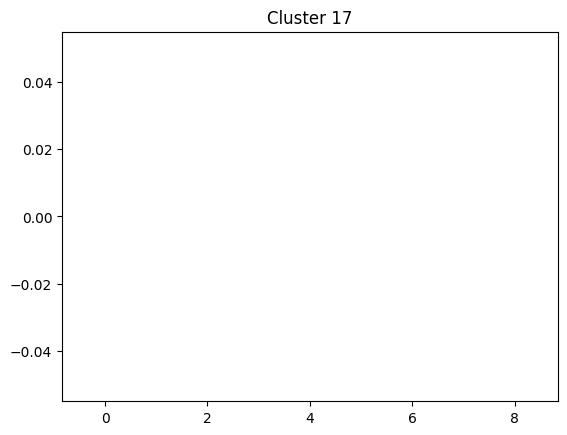

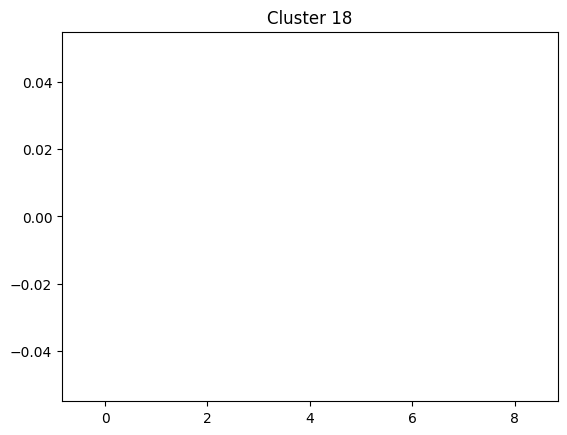

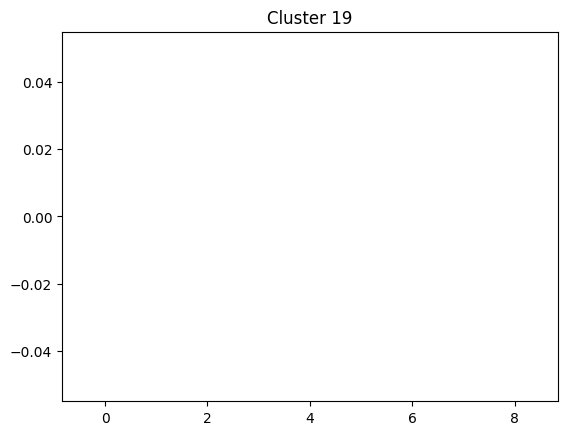

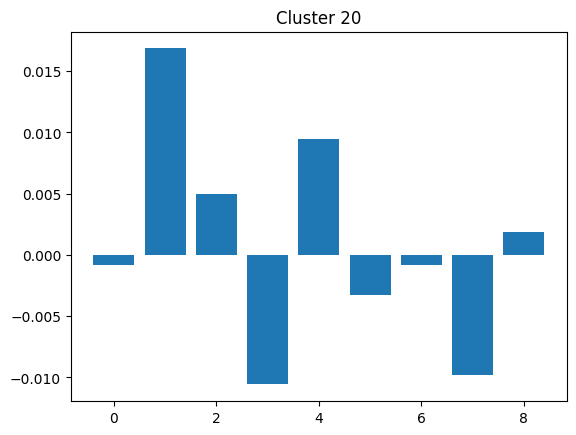

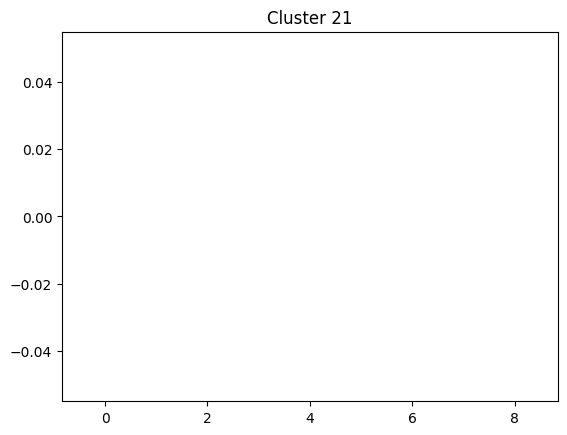

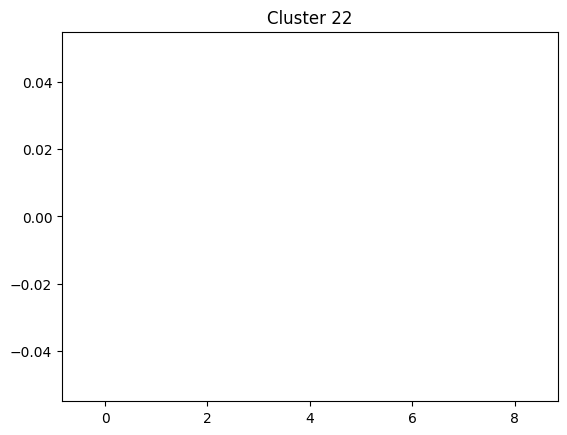

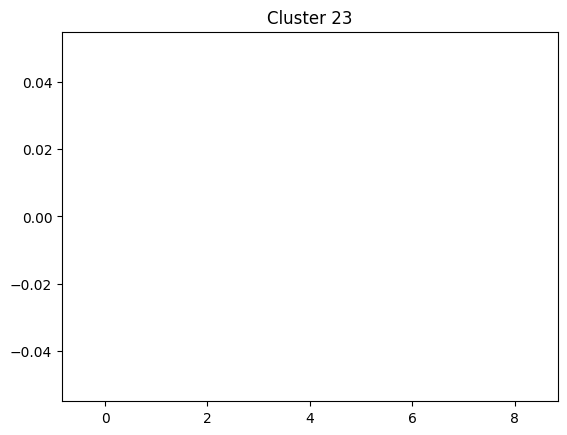

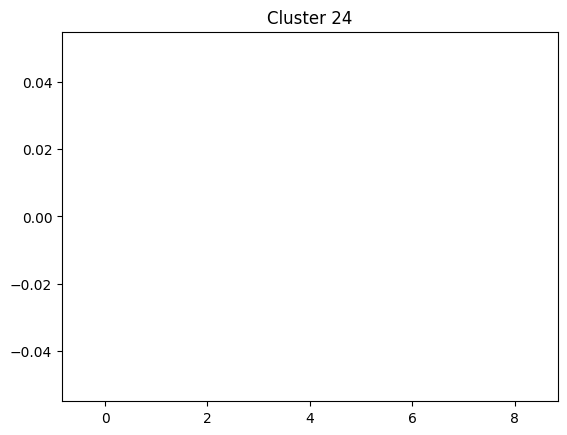

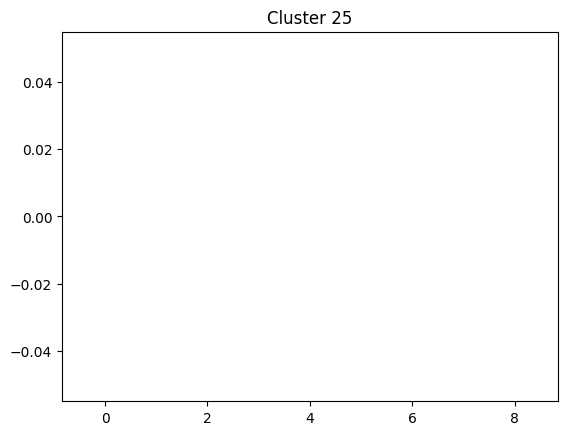

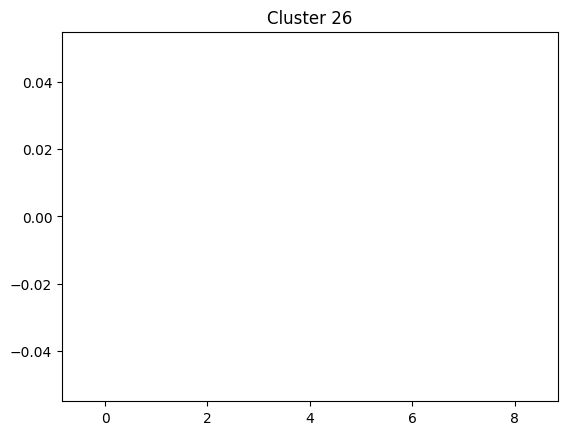

In [27]:
# bar plot feature for all clusters
import matplotlib.pyplot as plt

for clust in range(E_cluster.shape[1]):
    plt.figure()
    plt.bar(range(E_cluster.shape[0]), E_cluster[:, clust])
    plt.title(f"Cluster {clust}")
    plt.show()

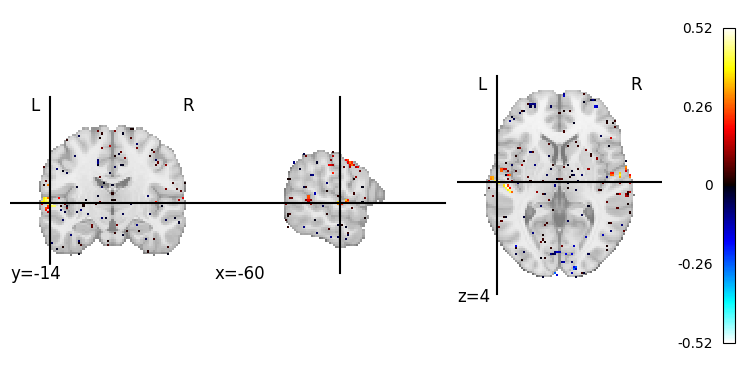

In [24]:
# plot the feature for the first emotion
from nilearn.plotting import plot_stat_map

plot_stat_map(
    E_avg_inv.slicer[..., 2],
    display_mode="ortho",
)